In [1]:
import copy

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroNN.gaia import fakemag_to_logsol
from astroNN.shared.matplotlib import pylab_style
from astropy.stats import mad_std
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from stellarperceptron.model import StellarPerceptron

pylab_style(paper=True)


def top_cbar(ax, mappable, text=None, labelpad=None, ticksformat=None):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("top", size="7%", pad="2%")
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal", format=ticksformat)
    cbar.set_label(text, labelpad=labelpad)
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_label_position("top")
    return cbar


def right_cbar(ax, mappable, text=None, labelpad=None, ticksformat=None):
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="7%", pad="2%")
    cbar = plt.colorbar(mappable, cax=cax, orientation="vertical", format=ticksformat)
    cbar.set_label(text, labelpad=labelpad)
    cax.xaxis.set_ticks_position("right")
    cax.xaxis.set_label_position("right")
    return cbar


xp_apogee_testing = h5py.File("./data_files/testing_set.h5", mode="r")

# this notebook is about inference from XP spectra, so we at least need XP spectra and APOGEE labels
good_idx = (
    (np.sum(np.isnan(xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()]), axis=1) == 0)
    & ~np.isnan(xp_apogee_testing["raw"]["teff"][()])
    & ~np.isnan(xp_apogee_testing["raw"]["logg"][()])
    & ~np.isnan(xp_apogee_testing["raw"]["m_h"][()])
)

val_labels = np.column_stack(
    [
        xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()],
        xp_apogee_testing["raw"]["bprp"][()],
        xp_apogee_testing["raw"]["jh"][()],
        xp_apogee_testing["raw"]["jk"][()],
        xp_apogee_testing["raw"]["teff"][()],
        xp_apogee_testing["raw"]["logg"][()],
        xp_apogee_testing["raw"]["m_h"][()],
        xp_apogee_testing["raw"]["logc19"][()],
        xp_apogee_testing["raw"]["g_fakemag"][()],
    ]
)[good_idx]

obs_names = np.stack(
    [
        *[f"bp{i}" for i in range(55)],
        *[f"rp{i}" for i in range(55)],
        "bprp",
        "jh",
        "jk",
        "teff",
        "logg",
        "m_h",
        "logebv",
        "g_fakemag",
    ]
)


nn_model = StellarPerceptron.load(
    "./trained_model/",
    checkpoint_epoch=3072,
    device="cuda:1",
    mixed_precision=True,
    compile_model=False,
)
print(
    f"Total number of parameters: {nn_model.get_parameters_sum()}, of which {nn_model.torch_model.diffusion_head.get_parameters_sum()} from the DDPM head"
)


Total number of parameters: 2053313, of which 132289 from the DDPM head


c:\Users\Henry\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)


(array([ 13.,  14.,  16.,  14.,  18.,  22.,  32.,  35.,  46.,  46.,  35.,
         54.,  67.,  71.,  57.,  82.,  79.,  79.,  84.,  81., 102., 102.,
        105.,  86.,  84.,  96., 101., 100., 110., 116.,  84., 112.,  99.,
        121., 113., 100., 137., 126., 107., 150., 156., 164., 206., 166.,
        177., 222., 220., 239., 213., 236., 223., 219., 208., 204., 199.,
        185., 164., 146., 125., 122.,  92.,  91.,  80.,  81.,  65.,  64.,
         65.,  65.,  49.,  43.,  55.,  41.,  44.,  42.,  33.,  49.,  66.,
         52.,  49.,  72.,  73.,  67.,  60.,  83.,  89., 123., 139., 156.,
        174., 177., 171., 148., 136., 117.,  81.,  39.,  22.,   4.,   0.,
          2.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        , 1.04999995, 1.10000002, 1.

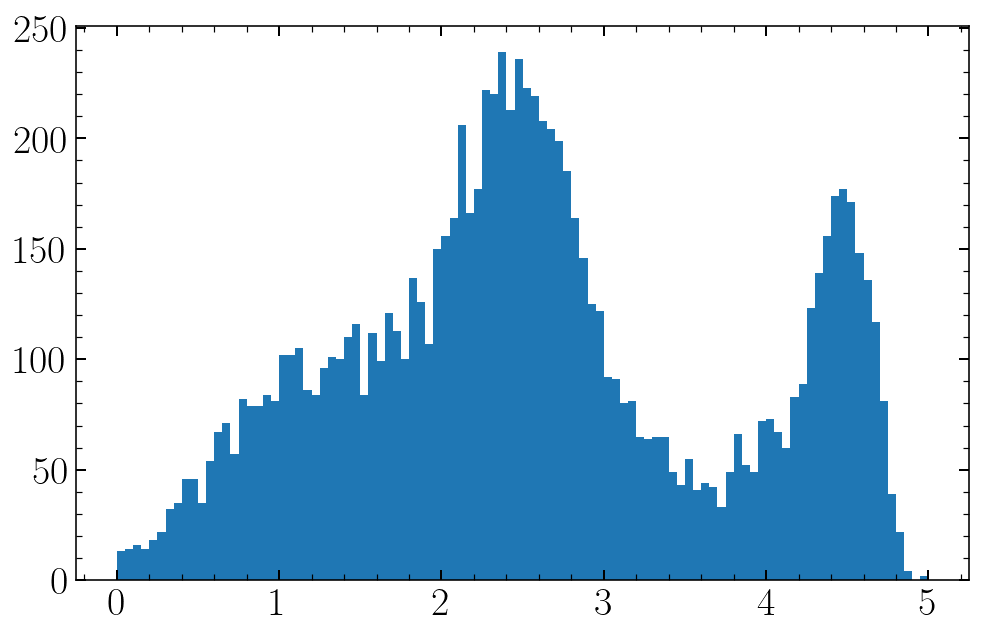

In [2]:
plt.hist(nn_model.predict_posterior([-9999.99], [0], "logg", size=10000), range=(0, 5), bins=100)

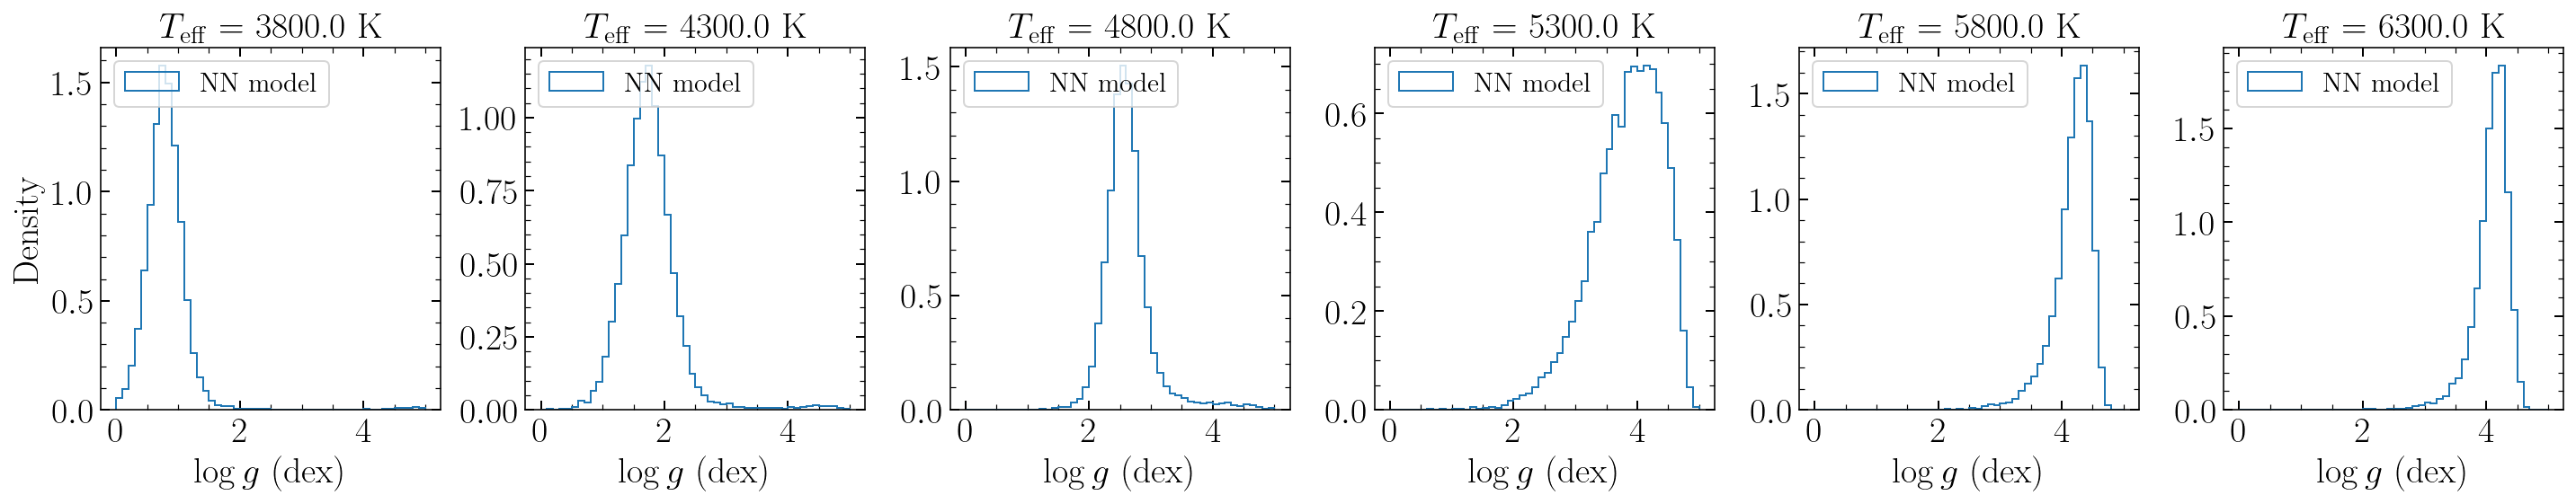

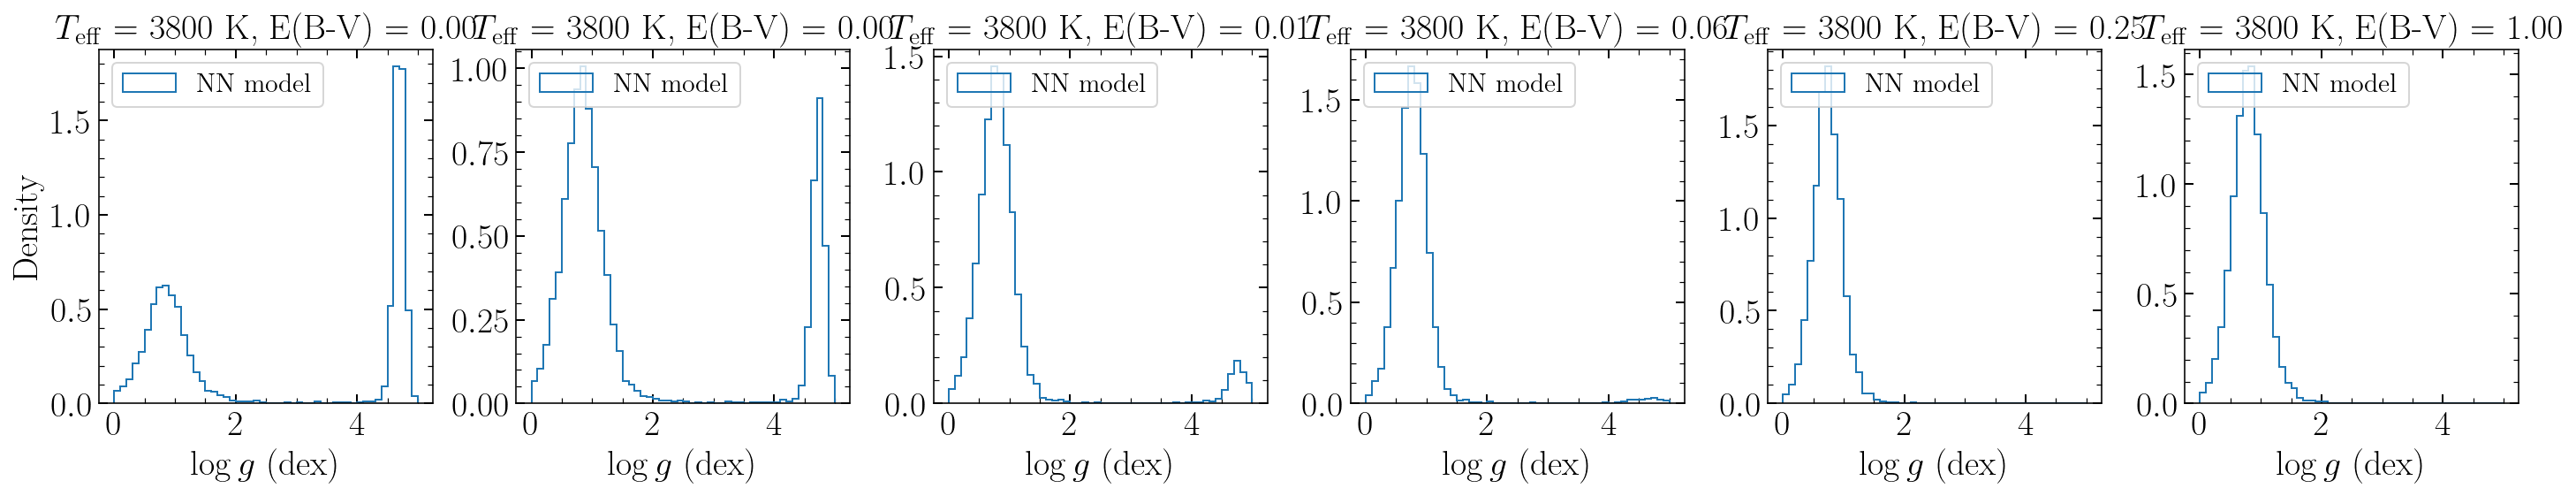

In [3]:
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for ax, t in zip(axes, np.linspace(3800, 6300, 6)):
    ax.set_title(f"$T_{{\\rm eff}}$ = {t} K")
    x = nn_model.predict_posterior([t], ["teff"], "logg", size=10000)
    _ = ax.hist(
        x[:, 0], range=(0, 5), bins=50, density=True, histtype="step", label="NN model"
    )
    ax.set_xlabel(r"$\log g$ (dex)")
    ax.legend(loc="upper left")
axes[0].set_ylabel("Density")
fig.tight_layout()


fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for ax, t in zip(axes, np.linspace(-7, 0, 6)):
    ax.set_title(f"$T_{{\\rm eff}}$ = 3800 K, E(B-V) = {np.exp(t):.2f}")
    x = nn_model.predict_posterior([3800, t], ["teff", "logebv"], "logg", size=10000)
    _ = ax.hist(
        x[:, 0], range=(0, 5), bins=50, density=True, histtype="step", label="NN model"
    )
    ax.set_xlabel(r"$\log g$ (dex)")
    ax.legend(loc="upper left")
axes[0].set_ylabel("Density")
fig.tight_layout()


[]

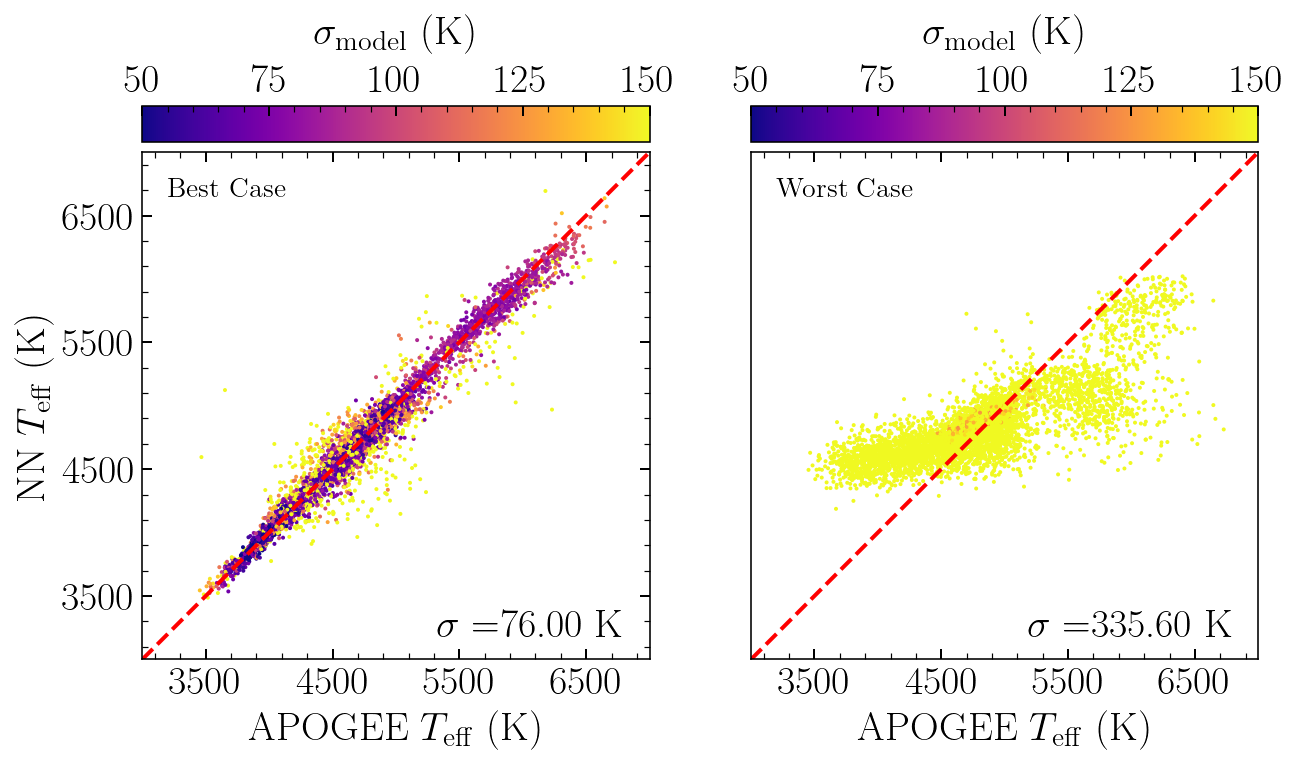

In [4]:
def plot_teff(ax, x, y, y_err=None, cmap="plasma", text=None, plot121=True):
    if y_err is None:
        custom_cmap = copy.copy(plt.get_cmap(cmap))
        custom_cmap.set_under(color="white")
        mappable = ax.hexbin(
            x,
            y,
            bins="log",
            extent=[3000, 7000, 3000, 7000],
            cmap=custom_cmap,
            vmin=1.1,
            rasterized=True,
        )
        top_cbar(ax, mappable, "log$_{10}$ N", labelpad=10)
    else:
        mappable = ax.scatter(
            x,
            y,
            c=y_err,
            cmap=cmap,
            vmin=50,
            vmax=150,
            s=1,
            rasterized=True,
        )
        top_cbar(ax, mappable, "$\\sigma_\\mathrm{model}$ (K)", labelpad=10)
    if plot121:
        ax.plot([3000, 7000], [3000, 7000], lw=2, ls="--", c="r")

    if text:
        ax.annotate(
            text, xy=(0.05, 0.95), xycoords=ax, fontsize=14, ha="left", va="top"
        )
    ax.annotate(
        f"$\\sigma=${mad_std(x-y, ignore_nan=True):.2f} K",
        xy=(0.95, 0.1),
        xycoords=ax,
        fontsize=20,
        ha="right",
        va="top",
    )
    ax.plot([-1, 3], [-1, 3], lw=2, ls="--", c="r")
    ax.set_xlim(3000, 7000)
    ax.set_ylim(3000, 7000)
    ax.set_xticks([3500, 4500, 5500, 6500])
    ax.set_yticks([3500, 4500, 5500, 6500])
    ax.set_aspect("equal", "box")
    ax.set_xlabel("APOGEE $T_\\mathrm{eff}$ (K)")
    ax.set_ylabel("NN $T_\\mathrm{eff}$ (K)")
    return mappable


fig, ax = plt.subplots(1, 2, figsize=(10, 5.0))

# Best Case
# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names).loc[:5000]
col_names = [
    *[f"bp{i}" for i in range(30)],
    *[f"rp{i}" for i in range(30)],
    *["jh", "jk", "bprp"],
]
val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    val_labels_shuffled, val_labels_names, ["teff"], size=1000
)
plot_teff(
    ax[0], val_labels_pd["teff"], x["teff"], y_err=x["teff_error"], text="Best Case"
)

# Worst Case
col_names = [
    *[f"bp{i}" for i in range(25, 55)],
    *[f"rp{i}" for i in range(25, 55)],
]

val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    val_labels_shuffled, val_labels_names, ["teff"], size=1000
)
plot_teff(
    ax[1], val_labels_pd["teff"], x["teff"], y_err=x["teff_error"], text="Worst Case"
)
ax[1].set_ylabel(None)
ax[1].set_yticks([])


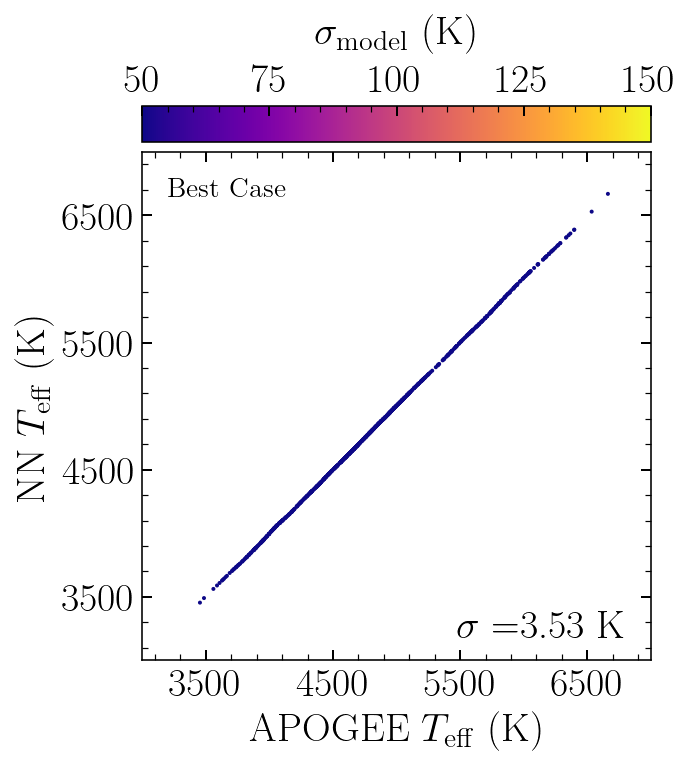

In [5]:
# Best Case
# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names).loc[:1000]
col_names = [
    *[f"bp{i}" for i in range(30)],
    *[f"rp{i}" for i in range(30)],
    *["jh", "jk", "teff"],
]
val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    val_labels_shuffled, val_labels_names, ["teff"]
)
fig, ax = plt.subplots(1, 1, figsize=(5.0, 5.0))
plot_teff(
    ax,
    val_labels_pd["teff"],
    x["teff"],
    y_err=x["teff_error"],
    plot121=False,
    text="Best Case",
)


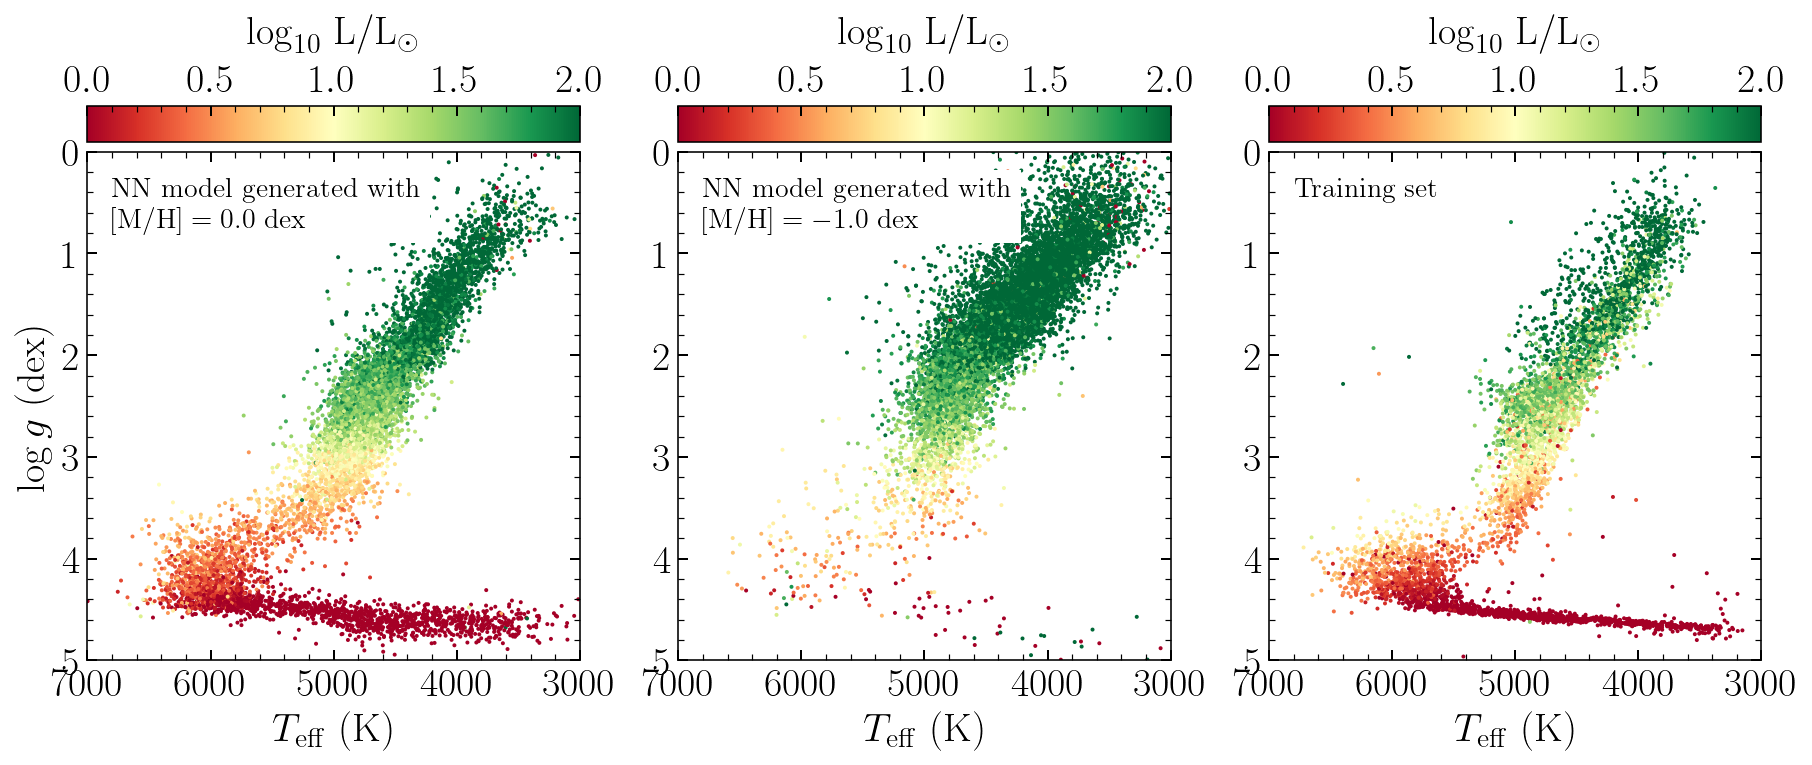

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15.0, 5.0))
conditional_m_h = 0.0
logg = nn_model.predict_posterior([conditional_m_h], ["m_h"], ["logg"], size=10240)[
    :, 0
]
teff = nn_model.predict_posterior(
    np.column_stack([conditional_m_h * np.ones_like(logg), logg]),
    ["m_h", "logg"],
    ["teff"],
    size=1,
    batch_size=1024,
)[0]
fakemag = nn_model.predict_posterior(
    np.column_stack(
        [conditional_m_h * np.ones_like(logg), logg, teff, -7.0 * np.ones_like(logg)]
    ),
    ["m_h", "logg", "teff", "logebv"],
    ["g_fakemag"],
    size=1,
    batch_size=1024,
)[0]
mappable = ax1.scatter(
    teff,
    logg,
    c=fakemag_to_logsol(fakemag, band="G"),
    s=1,
    vmin=0.0,
    vmax=2.0,
    cmap="RdYlGn",
)
ax1.set_xlim(7000, 3000)
ax1.set_ylim(5, 0)
ax1.set_xlabel("$T_{\\rm eff}$ (K)")
ax1.set_ylabel("$\\log g$ (dex)")
ax1.text(
    0.05,
    0.95,
    "NN model generated with \n $[\\mathrm{M/H}] = 0.0$ dex",
    transform=ax1.transAxes,
    fontsize=14,
    ha="left",
    va="top",
    backgroundcolor="white",
)
top_cbar(ax1, mappable, "$\\log_{10}$ L/L$_\\odot$", labelpad=10)

conditional_m_h = -1.0
logg = nn_model.predict_posterior([conditional_m_h], ["m_h"], ["logg"], size=10240)[
    :, 0
]
teff = nn_model.predict_posterior(
    np.column_stack([conditional_m_h * np.ones_like(logg), logg]),
    ["m_h", "logg"],
    ["teff"],
    size=1,
    batch_size=1024,
)[0]
fakemag = nn_model.predict_posterior(
    np.column_stack(
        [conditional_m_h * np.ones_like(logg), logg, teff, -7.0 * np.ones_like(logg)]
    ),
    ["m_h", "logg", "teff", "logebv"],
    ["g_fakemag"],
    size=1,
    batch_size=1024,
)[0]
mappable = ax2.scatter(
    teff,
    logg,
    c=fakemag_to_logsol(fakemag, band="G"),
    s=1,
    vmin=0.0,
    vmax=2.0,
    cmap="RdYlGn",
)
ax2.set_xlim(7000, 3000)
ax2.set_ylim(5, 0)
ax2.set_xlabel("$T_{\\rm eff}$ (K)")
ax2.text(
    0.05,
    0.95,
    "NN model generated with \n $[\\mathrm{M/H}] = -1.0$ dex",
    transform=ax2.transAxes,
    fontsize=14,
    ha="left",
    va="top",
    backgroundcolor="white",
)
top_cbar(ax2, mappable, "$\\log_{10}$ L/L$_\\odot$", labelpad=10)

rand_idx = np.sort(
    np.random.choice(
        np.arange(len(xp_apogee_testing["raw"]["teff"][()])), 10240, replace=False
    )
)
ax3.scatter(
    xp_apogee_testing["raw"]["teff"][rand_idx],
    xp_apogee_testing["raw"]["logg"][rand_idx],
    c=fakemag_to_logsol(xp_apogee_testing["raw"]["g_fakemag"][rand_idx], band="G"),
    s=1,
    vmin=0.0,
    vmax=2.0,
    cmap="RdYlGn",
)
ax3.set_xlim(7000, 3000)
ax3.set_ylim(5, 0)
ax3.set_xlabel("$T_{\\rm eff}$ (K)")
ax3.text(
    0.05,
    0.95,
    "Training set",
    transform=ax3.transAxes,
    fontsize=14,
    ha="left",
    va="top",
    backgroundcolor="white",
)
top_cbar(ax3, mappable, "$\\log_{10}$ L/L$_\\odot$", labelpad=10)


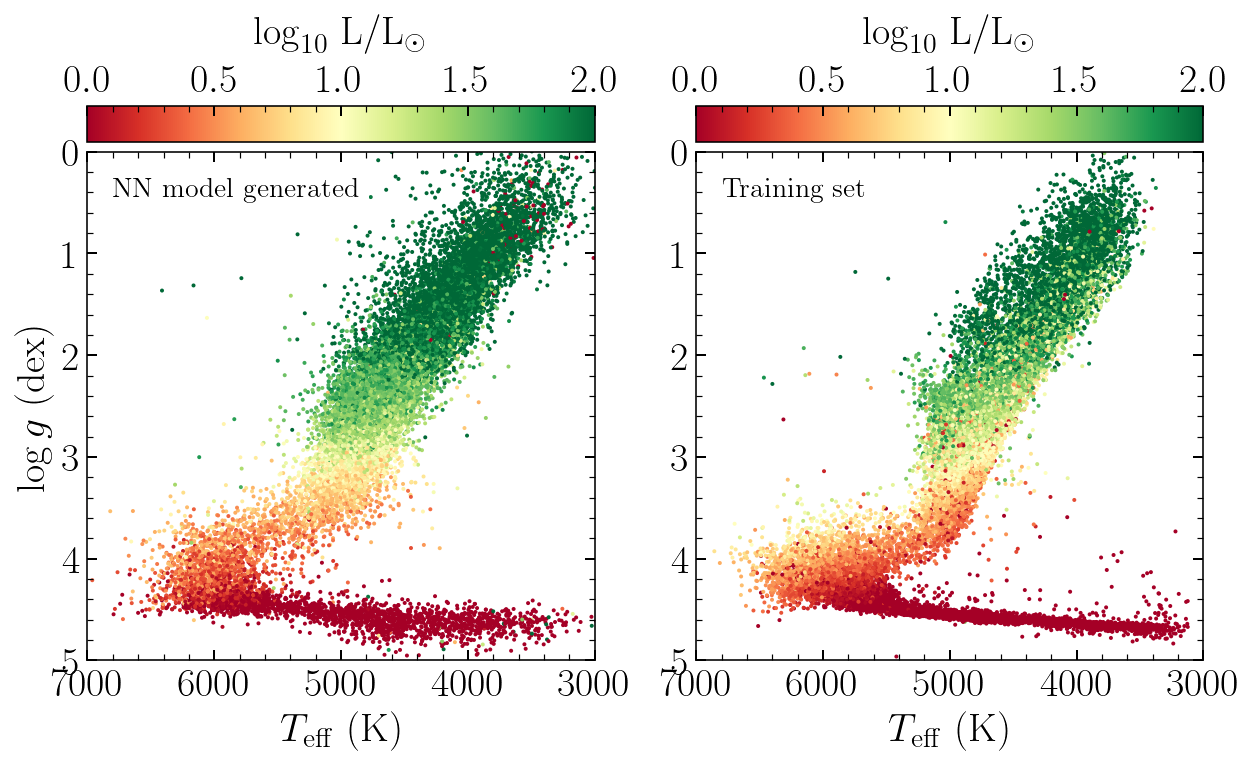

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.0, 5.0))
for i in range(100):
    conditional_m_h = nn_model.predict_posterior([-9999.99], [0], ["m_h"], size=1)[
        :, 0
    ]
    logg = nn_model.predict_posterior([conditional_m_h], ["m_h"], ["logg"], size=256)[
        :, 0
    ]

    teff = nn_model.predict_posterior(
        np.column_stack([conditional_m_h * np.ones_like(logg), logg]),
        ["m_h", "logg"],
        ["teff"],
        size=1,
        batch_size=1024,
    )[0]
    fakemag = nn_model.predict_posterior(
        np.column_stack(
            [conditional_m_h * np.ones_like(logg), logg, teff, -7.0 * np.ones_like(logg)]
        ),
        ["m_h", "logg", "teff", "logebv"],
        ["g_fakemag"],
        size=1,
        batch_size=1024,
    )[0]
    mappable = ax1.scatter(
        teff,
        logg,
        c=fakemag_to_logsol(fakemag, band="G"),
        s=1,
        vmin=0.0,
        vmax=2.0,
        cmap="RdYlGn",
    )
ax1.set_xlim(7000, 3000)
ax1.set_ylim(5, 0)
ax1.set_xlabel("$T_{\\rm eff}$ (K)")
ax1.set_ylabel("$\\log g$ (dex)")
ax1.text(
    0.05,
    0.95,
    "NN model generated",
    transform=ax1.transAxes,
    fontsize=14,
    ha="left",
    va="top",
    backgroundcolor="white",
)
top_cbar(ax1, mappable, "$\\log_{10}$ L/L$_\\odot$", labelpad=10)

ax2.scatter(
    xp_apogee_testing["raw"]["teff"],
    xp_apogee_testing["raw"]["logg"],
    c=fakemag_to_logsol(xp_apogee_testing["raw"]["g_fakemag"], band="G"),
    s=1,
    vmin=0.0,
    vmax=2.0,
    cmap="RdYlGn",
)
ax2.set_xlim(7000, 3000)
ax2.set_ylim(5, 0)
ax2.set_xlabel("$T_{\\rm eff}$ (K)")
ax2.text(
    0.05,
    0.95,
    "Training set",
    transform=ax2.transAxes,
    fontsize=14,
    ha="left",
    va="top",
    backgroundcolor="white",
)
top_cbar(ax2, mappable, "$\\log_{10}$ L/L$_\\odot$", labelpad=10)


In [8]:
# Best Case
# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names).loc[:10]
col_names = [
    *[f"bp{i}" for i in range(30)],
    *[f"rp{i}" for i in range(30)],
    *["jh", "jk", "teff"],
]
val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_posterior(val_labels_shuffled, val_labels_names, "teff")


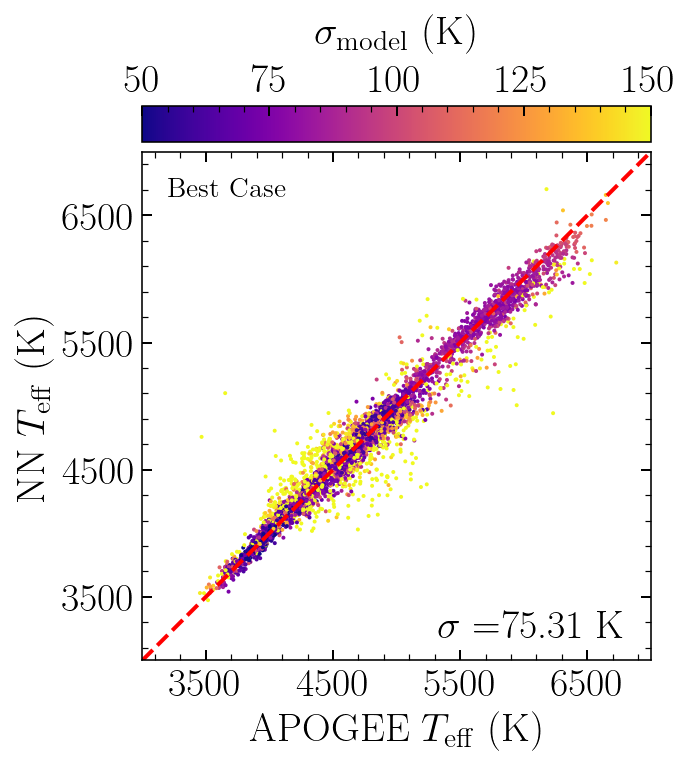

In [9]:
# Best Case
# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names).loc[:5000]
col_names = [
    *[f"bp{i}" for i in range(54, -1, -1)],
    *[f"rp{i}" for i in range(54, -1, -1)],
    *["jh", "jk", "bprp"],
]
val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    val_labels_shuffled, val_labels_names, ["teff", "logg", "m_h"]
)
fig, ax = plt.subplots(1, 1, figsize=(5.0, 5.0))
plot_teff(ax, val_labels_pd["teff"], x["teff"], y_err=x["teff_error"], text="Best Case")


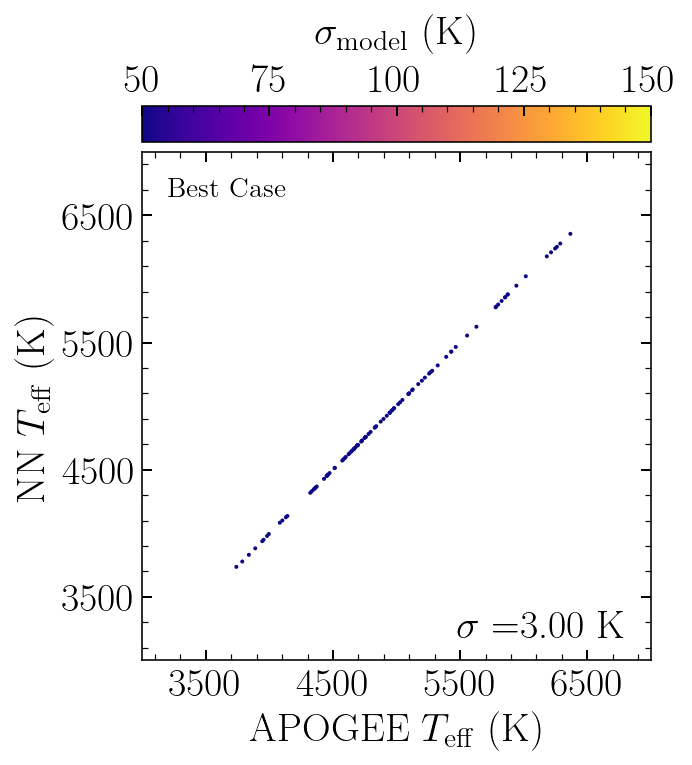

In [10]:
# Best Case
# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names).loc[:100]
col_names = [
    *[f"bp{i}" for i in range(54, 42, -1)],
    "teff",
    *[f"bp{i}" for i in range(42, -1, -1)],
    *[f"rp{i}" for i in range(54, -1, -1)],
    *["jh", "jk", "bprp"],
]
val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    val_labels_shuffled, val_labels_names, ["teff", "logg", "m_h"]
)
fig, ax = plt.subplots(1, 1, figsize=(5.0, 5.0))
plot_teff(
    ax,
    val_labels_pd["teff"],
    x["teff"],
    y_err=x["teff_error"],
    plot121=False,
    text="Best Case",
)


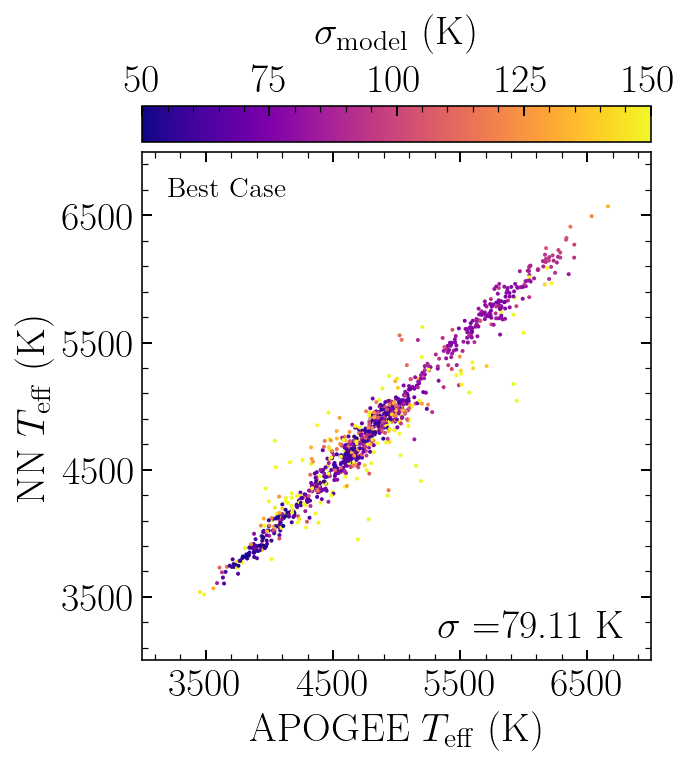

In [11]:
# Best Case
# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names).loc[:1000]
col_names = [
    *[f"bp{i}" for i in range(30)],
    *[f"rp{i}" for i in range(30)],
    *[
        "jh",
        "jk",
        "bprp",
    ],
]
val_labels_shuffled = val_labels_pd[col_names]
test_data_length = len(val_labels_pd)
val_labels_names = np.tile(col_names, (test_data_length, 1))
x = nn_model.predict_summary(
    val_labels_shuffled, val_labels_names, ["teff", "logg", "m_h"]
)
fig, ax = plt.subplots(1, 1, figsize=(5.0, 5.0))
plot_teff(
    ax,
    val_labels_pd["teff"],
    x["teff"],
    y_err=x["teff_error"],
    plot121=False,
    text="Best Case",
)


In [12]:
import numpy as np

from stellarperceptron.model import StellarPerceptron
from utils.gaia_utils import xp_spec_online

# Gaia DR3 source_id as integer
gdr3_source_id = 2130706307446806144

bprp_coeffs = xp_spec_online(gdr3_source_id, absolute_flux=False)
nn_model = StellarPerceptron.load(
    "./trained_model_2/", device="cuda:1", mixed_precision=True
)
# Give the context of a star by giving XP coefficients to the NN model
x = nn_model.predict_summary(
    np.concatenate([bprp_coeffs["bp"][:32], bprp_coeffs["rp"][:32]]),
    [*[f"bp{i}" for i in range(32)], *[f"rp{i}" for i in range(32)]],
    ["teff", "logg", "m_h"],
)
x


ModuleNotFoundError: No module named 'utils'